# Readin Timestamps and Match to a Common Timeframe

Because both the camera and eye trackers are in free-run mode rather than triggered, we have to match the timestamps between the multiple collection devices post-hoc.  This involves first converting their timestamps from internal device time to Unix time. Next, we create a common timestamp set that is uniformly measured in time. Finally, we match each device time to its nearest common timestamp time, repeating a frame in the case of dropped frames. 

## Dependencies

In [1]:
import os, stat
import numpy as np
import utils.run_analysis as ana
import matplotlib.pyplot as plt

## Parameters

In [2]:
base_dir = '/data_repo/bravo'
data_dir = os.path.join(base_dir, 'raw_data')
output_dir = os.path.join(base_dir, 'analysis')
target_fps = 200


## Fix Permissions
When collecting, jupyter has to run as SUDO for keyboard communication. This makes some files and folders with sudo permissions, even for read. 

In Terminal:
'sudo chmod -R 777 /data_repo/bravo'

## Specify Directories for Exmaple

In [6]:
example_subject = 'jf'
example_trial = 'cell_phone_1'
example_camera = 'cy'
trial_directory = os.path.join(data_dir, example_subject, example_trial, 'pre')

#ximea (scene cameras)
ximea_timestamp_file = os.path.join(trial_directory, 'scene_camera', f'timestamps_{example_camera}.tsv')
ximea_timesync_file = os.path.join(trial_directory, 'scene_camera', f'timestamp_camsync_{example_camera}.tsv')

#pupil (eye cameras)
pupil_timestamp_file = os.path.join(trial_directory, 'eye_camera','000', 'pupil_timestamps.npy')
pupil_annotations_file = os.path.join(trial_directory, 'eye_camera','000', 'annotation_timestamps.npy')

analysis_folder = os.path.join(output_dir, example_subject, example_trial,'')
try:
    os.makedirs(analysis_folder)
except:
    print('Folder Already Made!')

Folder Already Made!


## Convert to unified wall clock time
Cameras collect in camera time. We need to sync this to Unix time

In [7]:
ximea_timestamps = ana.convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)

ximea_timestamp_converted_path = os.path.join(analysis_folder,f'timestamps_converted_{example_camera}.tsv')

#np.savetxt(od_ximea_timestamp_converted_path, od_ximea_timestamps, fmt='%10.5f', delimiter='\t')
np.savetxt(ximea_timestamp_converted_path, ximea_timestamps, fmt='%10.5f', delimiter='\t')

Time Elapsed: 135.3787317276001 seconds
Time Drift pre to post: 0.018285096399949907 seconds
1574810720.7608986


## How Many Frames Were Lost/Skipped?

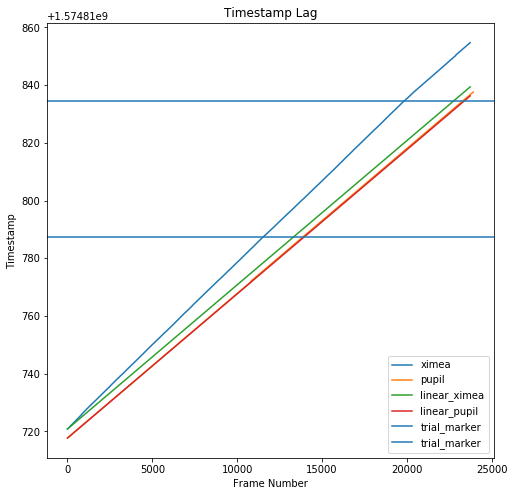

In [8]:
pupil_num='000'

pupil_ts = np.load(pupil_timestamp_file)[::2]
#pupil_ts_gaze = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'gaze_timestamps.npy'))
#pupil_ts_eye0 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye0_timestamps.npy'))
#pupil_ts_eye1 = np.load(os.path.join(pupil_save_dir_name, pupil_num, 'eye1_timestamps.npy'))
pupil_annotations = np.load(pupil_annotations_file)

#ximea timestamps
with open(ximea_timestamp_converted_path, 'r') as f:
    timestamps_ximea = list(zip(line.strip().split('\t') for line in f))
    timestamps_ximea = np.squeeze(np.array(timestamps_ximea[1:]).astype('float'))
    timestamps_ximea = timestamps_ximea[:,-1]

linear_ximea = np.arange(0,len(timestamps_ximea)*0.005, 0.005)+timestamps_ximea[0]
linear_pupil = np.arange(0, len(timestamps_ximea)*0.005, 0.005)+pupil_ts[0]

plt.figure(figsize=(8,8))
plt.plot(timestamps_ximea, label='ximea')
plt.plot(pupil_ts, label='pupil')
#plt.plot(pupil_ts_gaze, label='gaze')
# plt.plot(pupil_ts_eye0, label='vid_eye0')
# plt.plot(pupil_ts_eye1, label='vid_eye1')
plt.plot(linear_ximea, label='linear_ximea')
plt.plot(linear_pupil, label='linear_pupil')

[plt.axhline(pupil_annotations[i], label='trial_marker') for i in range(len(pupil_annotations))]
#plt.axhline(pupil_annotations[1], label='trial_marker')

plt.legend()
plt.xlabel('Frame Number')
plt.ylabel('Timestamp')
plt.title('Timestamp Lag')
plt.legend()

We've lost a decent number of ximea frames, but pupil looks pretty good. Lets ID where the missing frames are first.

In [6]:
dt = timestamps_ximea[1:] - timestamps_ximea[:-1]
pfl = len(dt[dt >= 0.01])/len(dt)
print(f'Percentage Frames Dropped: {pfl}')

Percentage Frames Dropped: 0.0405285972812592


## Task Marking

*** FOR THIS PRELIMINARY DATA WHICH HAS NO TASK END MARKER ONLY ***   
*** When we move to a second calibration AFTER the task, need to change this code ***

The LAST pupil annotation should be the beginning of the task, and all data AFTER that is task data. Mark it as such.

In [17]:
if(example_trial == 'cell_phone_1'):
    start_task_time = pupil_annotations[-2]
    end_task_time = pupil_annotations[-1]
else:
    start_task_time = pupil_annotations[-1]
    end_task_time = timestamps_ximea[-1]

## Create Non-Lossy Timeframe & Assign Pupil & Ximea Frames to it
For now, frame numbers are simply repeated if there is a frame drop. This seems better than interpolating an image, but will ask Bruno about this

In [18]:
start_timestamp = np.max((timestamps_ximea[0], pupil_ts[0]))
end_timestamp = np.min((timestamps_ximea[-1], pupil_ts[-1]))
common_timeline = np.arange(start_timestamp, end_timestamp, 1./target_fps)

In [19]:
ximea_common_timeline_match = np.zeros_like(common_timeline)
pupil_common_timeline_match = np.zeros_like(common_timeline)
during_calibration = np.zeros_like(common_timeline)
during_task = np.zeros_like(common_timeline)

for i, t in enumerate(common_timeline):
    ximea_common_timeline_match[i] = np.argmin(np.abs(timestamps_ximea - t))
    pupil_common_timeline_match[i] = np.argmin(np.abs(pupil_ts - t))
    if((t > start_task_time) and (t < end_task_time)):
        during_task[i] = 1
    #mark calibration later
        #during_calibration

In [20]:
nframes = len(np.where(during_task ==1)[0])
print(f'{nframes/target_fps} Seconds of Task')

47.11 Seconds of Task


## Save Timeframe and Marks for Later Use

Our new timeline can be used to align pupil labs data to our camera data and create movies for spatiotemporal analysis!

In [21]:
analysis_folder

'/data_repo/bravo/analysis/jf/cell_phone_1/'

In [22]:
common_timeline_table = np.array((common_timeline, ximea_common_timeline_match, pupil_common_timeline_match, during_task, during_calibration)).T
common_timeline_table_colnames = 'common_timeline\tximea_frame\tpupil_frame\tduring_task\tduring_calibration'
common_timeline_file = os.path.join(analysis_folder,'common_timeline.tsv')
np.savetxt(common_timeline_file, common_timeline_table, delimiter='\t', header=common_timeline_table_colnames)

## Run Script on All Trials

I put all the code in a nice script! Run this script on all our trials to create respective timestamps for each

In [27]:
import itertools as it
import read_match_timestamps as rmt
import imp
imp.reload(rmt)

subjects = ['jf']
tasks = ['cell_phone', 'laptop']
repititions = ['1','2','3']
iterator = it.product(subjects, tasks, repititions)

for iteration in iterator:
    subject, task, rep = iteration
    trial = f'{task}_{rep}'
    print('*')
    if(os.path.isdir(os.path.join(base_dir,'raw_data', subject, trial))):
        table = rmt.read_match_timestamps(base_dir, target_fps, subject, trial, num_cameras=1)



*
Folder /data_repo/bravo/analysis/jf/cell_phone_1/ Already Made!
Time Elapsed: 135.3787317276001 seconds
Time Drift pre to post: 0.018285096399949907 seconds
1574810720.7608986
Task Lasted: 47.111611127853394 seconds.
*
Folder /data_repo/bravo/analysis/jf/cell_phone_2/ Already Made!
Time Elapsed: 135.2961688041687 seconds
Time Drift pre to post: 0.018304411831309153 seconds
1574810921.4236894
Task Lasted: 72.01901483535767 seconds.
*
Folder /data_repo/bravo/analysis/jf/cell_phone_3/ Already Made!
Time Elapsed: 136.0369143486023 seconds
Time Drift pre to post: 0.015845579397705478 seconds
1574811110.9803076
Task Lasted: 82.39471745491028 seconds.
*
Folder /data_repo/bravo/analysis/jf/laptop_1/ Already Made!
Time Elapsed: 136.31205368041992 seconds
Time Drift pre to post: 0.015955095580238776 seconds
1574811439.918789
Task Lasted: 73.00651121139526 seconds.
*
Folder /data_repo/bravo/analysis/jf/laptop_2/ Already Made!
Time Elapsed: 136.78098344802856 seconds
Time Drift pre to post: 0.01